Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 

from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Load in and modify dataframes

In [2]:
df_nlp = pd.read_csv('fin_cleaned_nlp.csv')

In [3]:
df_nlp.head()

,Unnamed: 0,User,Text,Clean
0,0,PDXorax,"The Lump of Labor doesn't apply in this case,...",the lump of labor doesn apply in this case we ...
1,1,PrincePizza1,"I think things ""getting better"" to people lik...",think things getting better to people like thi...
2,2,Marmar79,Thank you. This made my day He so edgy.\n\nEd...,thank you this made my day he so edgy edit don...
3,3,IRISHE3,I just wish politicians would put the money s...,just wish politicians would put the money shit...
4,4,RonZiggy,Climate change as well. Wow...just wow What i...,climate change as well wow just wow what is th...


In [4]:
#Set index to User column
df_nlp.set_index('User',inplace=True)

In [5]:
#Drop the unnamed 0 column
df_nlp.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [6]:
df_nlp.dropna(axis=0,inplace=True)

In [7]:
df_nlp.head()

,Text,Clean
User,,
PDXorax,"The Lump of Labor doesn't apply in this case,...",the lump of labor doesn apply in this case we ...
PrincePizza1,"I think things ""getting better"" to people lik...",think things getting better to people like thi...
Marmar79,Thank you. This made my day He so edgy.\n\nEd...,thank you this made my day he so edgy edit don...
IRISHE3,I just wish politicians would put the money s...,just wish politicians would put the money shit...
RonZiggy,Climate change as well. Wow...just wow What i...,climate change as well wow just wow what is th...


In [8]:
df_nlp.shape

(3711, 2)

In [9]:
df_yang_train = pd.read_csv('fin_users_train.csv')

In [10]:
df_yang_test = pd.read_csv('fin_users_test.csv')

In [11]:
df_yang_train.set_index('Unnamed: 0',inplace=True)

In [12]:
df_yang_test.set_index('Unnamed: 0',inplace=True)

In [13]:
#Select only the yang users in the dataset
df_yang_tr = df_yang_train[df_yang_train['target']==1]

In [14]:
#Select only the yang users in the dataset
df_yang_ts = df_yang_test[df_yang_test['target']==1]

In [15]:
#Combine Yang users to a single dataframe
df_users = df_yang_ts.append(df_yang_tr)

In [16]:
df_users.shape

(937, 1)

In [17]:
#Use an inner join to only return a dataframe of yang users with comments on the r/politics subreddit
df_use = pd.concat([df_nlp,df_users],join='inner',axis=1)

In [18]:
df_use.shape

(596, 3)

In [19]:
df_use.head()

,Text,Clean,target
PDXorax,"The Lump of Labor doesn't apply in this case,...",the lump of labor doesn apply in this case we ...,1
JivingMango,"Good article, saw that Yang was one of the fi...",good article saw that yang was one of the firs...,1
grandtheftdragon,"Experience is a liability. ""Republican talkin...",experience is liability republican talking poi...,1
michaelTison,How many direct questions was he asked? Not r...,how many direct questions was he asked not rea...,1
RealTeaching,Who can we get to run against this guy???? H...,who can we get to run against this guy he need...,1


NLP

In [20]:
tokenizer = RegexpTokenizer('\s+', gaps=True)
porter = PorterStemmer()
stops = set(stopwords.words('english'))

In [21]:
#function to just remove stop words from a string
def just_stop(text):
    processed_tokens=[]
    tokens = tokenizer.tokenize(text)
    for token in tokens:
        if token not in stops:
            processed_tokens.append(token)
    return(" ".join(processed_tokens))

In [22]:
df_use['Stop Only']=df_use['Clean'].apply(just_stop)

In [23]:
#To generate my LDAvis, I need to remove Yang since that name is used too often and causes poor topic modeling if used
stops.add('yang')

In [24]:
#Actual function that tokenizes text, removes stop words, lemmatizes the tokens, and returns the tokens joined with a space
def stop_and_porter(text):
    processed_tokens=[]
    tokens = tokenizer.tokenize(text)
    for token in tokens:
        if token not in stops:
            processed_tokens.append(porter.stem(token))
    return(" ".join(processed_tokens))

In [25]:
df_use['Final']=df_use['Clean'].apply(stop_and_porter)

In [26]:
df_use.head()

,Text,Clean,target,Stop Only,Final
PDXorax,"The Lump of Labor doesn't apply in this case,...",the lump of labor doesn apply in this case we ...,1,lump labor apply case looking rd labor automat...,lump labor appli case look rd labor autom with...
JivingMango,"Good article, saw that Yang was one of the fi...",good article saw that yang was one of the firs...,1,good article saw yang one first qualify debate...,good articl saw one first qualifi debat poll i...
grandtheftdragon,"Experience is a liability. ""Republican talkin...",experience is liability republican talking poi...,1,experience liability republican talking points...,experi liabil republican talk point work take ...
michaelTison,How many direct questions was he asked? Not r...,how many direct questions was he asked not rea...,1,many direct questions asked really multiple ti...,mani direct question ask realli multipl time r...
RealTeaching,Who can we get to run against this guy???? H...,who can we get to run against this guy he need...,1,get run guy needs retire soon look lean yang c...,get run guy need retir soon look lean campaign...


Create Wordcloud

In [27]:
#One of the easiest ways to see what a group is talking about is to generate a wordcloud

In [28]:
#Create a string of all comments collected from Yang users on r/politics
wordcloud_text_string = ""
for i in range(df_use.shape[0]):
    wordcloud_text_string += str(df_use.iloc[i,3])

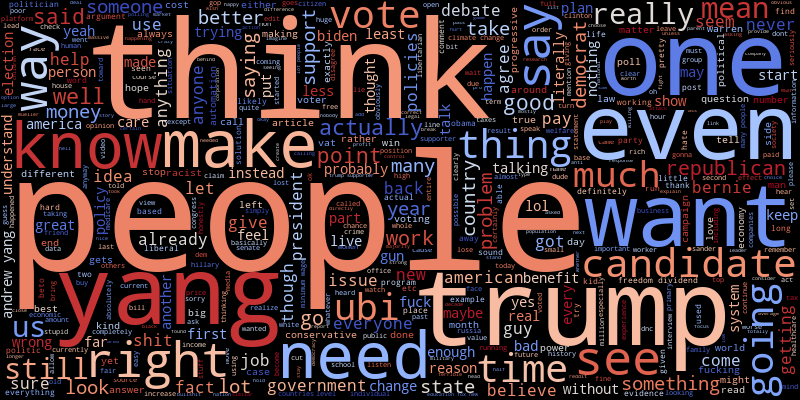

In [29]:
#Generate the wordcloud image
wordcloud = WordCloud(background_color="black", max_words=500, width=800, height=400, colormap='coolwarm')
wordcloud.generate(wordcloud_text_string)
wordcloud.to_image()

Perform LDA topic analysis and visualization

In [30]:
#Wordclouds generally just return the most common words which isn't that helpful, 
##let's try doing some actual topic modeling

In [31]:
#Generate a count vectorization
cv = CountVectorizer(min_df=10,ngram_range=[1,2])
cv_arr = cv.fit_transform(df_use['Final'])
df_vect = pd.DataFrame(cv_arr.toarray(), columns=cv.get_feature_names())
df_vect.head()

,abandon,abhorr,abil,abl,abl get,abolish,abort,absolut,absolut noth,absurd,...,york,young,young peopl,younger,youth,youtub,yr,yup,zero,zone
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
#Get data in the right format for LDA analysis
#Code modified from a previous GA cohort's lecture notes
texts = [df_vect.columns[df_vect.loc[index,:].to_numpy().nonzero()] for index in df_vect.index]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [33]:
#Code modified from a previous GA cohort's lecture notes
ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 4,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    random_state=42,            # initialize a random state
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [34]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.023454  0.004820       1        1  45.707302
0     -0.020763  0.010895       2        1  43.721794
3     -0.006779 -0.016326       3        1   6.511592
2      0.004089  0.000610       4        1   4.059305, topic_info=     Category        Freq       Term       Total  loglift  logprob
70    Default  370.000000       like  370.000000  30.0000  30.0000
95    Default  362.000000      peopl  362.000000  29.0000  29.0000
47    Default  359.000000        get  359.000000  28.0000  28.0000
518   Default  355.000000      would  355.000000  27.0000  27.0000
370   Default  284.000000       know  284.000000  26.0000  26.0000
401   Default  278.000000       much  278.000000  25.0000  25.0000
502   Default  335.000000      think  335.000000  24.0000  24.0000
116   Default  268.000000        see  268.000000  23.0000  23.0000
140   Default  294.000000       want  294.000000  22.0000  22.0000
91    Default  328.000000        one  328.000000  21.0000  21.0000
49    Default  327.000000         go  327.000000  20.0000  20.0000
385   Default  328.000000       make  328.000000  19.0000  19.0000
509   Default  313.000000      trump  313.000000  18.0000  18.0000
155   Default  236.000000     better  236.000000  17.0000  17.0000
465   Default  309.000000        say  309.000000  16.0000  16.0000
129   Default  303.000000       time  303.000000  15.0000  15.0000
450   Default  265.000000     realli  265.000000  14.0000  14.0000
128   Default  290.000000      thing  290.000000  13.0000  13.0000
245   Default  287.000000       also  287.000000  12.0000  12.0000
84    Default  296.000000       need  296.000000  11.0000  11.0000
399   Default  218.000000      money  218.000000  10.0000  10.0000
573   Default  233.000000       give  233.000000   9.0000   9.0000
34    Default  292.000000       even  292.000000   8.0000   8.0000
273   Default  284.000000     candid  284.000000   7.0000   7.0000
231   Default  249.000000        tri  249.000000   6.0000   6.0000
16    Default  219.000000      chang  219.000000   5.0000   5.0000
125   Default  266.000000       take  266.000000   4.0000   4.0000
60    Default  229.000000        job  229.000000   3.0000   3.0000
497   Default  250.000000       talk  250.000000   2.0000   2.0000
111   Default  286.000000      right  286.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
678    Topic4    9.314898      month  159.068558   0.3664  -6.7432
1278   Topic4    6.956786  healthcar   97.105865   0.5681  -7.0351
629    Topic4   10.094412      start  187.448196   0.2826  -6.6628
368    Topic4    9.665257       keep  178.980713   0.2854  -6.7063
154    Topic4   10.712040       back  215.193130   0.2040  -6.6035
575    Topic4   10.299782        got  203.614441   0.2201  -6.6427
380    Topic4    9.936231       live  193.922104   0.2329  -6.6786
232    Topic4   11.694798       vote  265.200012   0.0828  -6.5157
116    Topic4   11.677748        see  268.935181   0.0674  -6.5171
313    Topic4    8.021400     effect  135.985901   0.3737  -6.8927
497    Topic4   10.935927       talk  250.414246   0.0731  -6.5828
60     Topic4   10.443475        job  229.798691   0.1129  -6.6288
1996   Topic4    8.718154     system  161.289093   0.2864  -6.8094
155    Topic4   10.506461     better  236.127518   0.0918  -6.6228
401    Topic4   11.376019       much  278.494568   0.0063  -6.5433
152    Topic4   11.104298     actual  268.308319   0.0194  -6.5675
70     Topic4   12.633075       like  370.174927  -0.1735  -6.4385
502    Topic4   12.064815      think  335.160767  -0.1202  -6.4845
1166   Topic4    8.528500       find  158.301224   0.2831  -6.8314
47     Topic4   11.678273        get  359.997345  -0.2242  -6.5171
95     Topic4   11.465144      peopl  362.123657  -0.2485  -6.5355
129    Topic4   10.737053       time  303.611969  -0.1379  -6.6011
140    Topic4  